In [67]:
#Make sure to only keep libraries we use!
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yfin
import time
from datetime import timedelta
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
import pandas as pd

In [68]:
asset_lst = ['AAPL', 'BAC', 'GOOG', 'GS', 'JPM', 'KO', 'MSFT', 'NVDA', 'PG', 'WMT']

# Task 1. Clustering

### Generate and standardize features for clustering

In [69]:
start_date_t1 = '2017-01-01' # inclusive
end_date_t1 = '2019-01-02' # exclusive

MyData_t1 = yfin.download(asset_lst,start=start_date_t1,end=end_date_t1)
MyData_t1 = MyData_t1.dropna()

results = []

for stock in asset_lst:
    stock_data = MyData_t1.xs(stock, level='Ticker', axis=1) #get ticker cross-section
    price_open = stock_data['Open']
    price_close = stock_data['Adj Close']
    daily_vol = stock_data['Volume']

    r = (price_close - price_open) / price_open
    avg_r = r.mean()
    var_r = r.var()
    avg_vol = daily_vol.mean()
    var_vol = daily_vol.var()

    results.append({'Stock': stock, 'Avg_R': avg_r, 'Var_R': var_r, 'Avg_Vol': avg_vol, 'Var_Vol': var_vol})

features = pd.DataFrame(results).set_index('Stock')
#standardize features
scaler = preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)


[*********************100%***********************]  10 of 10 completed


## Method 1: K-Means

In [70]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10, max_iter=100, random_state=42)
kmeans.fit(features_scaled)
k_means_result = features_scaled.copy()
k_means_result['Cluster'] = kmeans.labels_

print('Number of Iterations:',kmeans.n_iter_)
print('Inertia:',kmeans.inertia_,'\n')

# Group assets by cluster
k_means_clusters = defaultdict(list)
for i, group in enumerate(kmeans.labels_):
    k_means_clusters[group].append(asset_lst[i])

# Print assets by cluster
for cluster in sorted(k_means_clusters.keys()):
    print(f"Cluster {cluster}:")
    print(f'Centered at: {kmeans.cluster_centers_[cluster]}')
    for asset in k_means_clusters[cluster]:
        print(f"  {asset}")
    print()

Number of Iterations: 2
Inertia: 3.5018745580227955 

Cluster 0:
Centered at: [-0.73771598 -0.20948395 -0.39695708 -0.34223639]
  BAC
  GS
  JPM
  KO
  PG
  WMT

Cluster 1:
Centered at: [1.48686092 2.72924546 2.94306795 2.99904907]
  NVDA

Cluster 2:
Centered at: [ 0.97981165 -0.4907806  -0.18710849 -0.31521025]
  AAPL
  GOOG
  MSFT



## Method 2: Hierarchical Agglomerative Clustering (HAC)

In [71]:
linkage_types = ['ward','complete','average','single']

max_silhouette = -1
optimal_linkage_type = ''
hac_result = features_scaled.copy()

for linkage_type in linkage_types:

    hac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage=linkage_type)
    temp_labels = hac.fit_predict(features_scaled)
    temp_result = hac_result.copy()
    temp_result['Cluster'] = temp_labels

    hac_silhouette = silhouette_score(temp_result.drop('Cluster',axis=1), temp_labels)
    print(f"Linkage type '{linkage_type}' has silhouette score: {hac_silhouette}")
    if hac_silhouette > max_silhouette:
        max_silhouette = hac_silhouette
        optimal_linkage_type = linkage_type
        hac_labels = temp_labels
        hac_result = temp_result

print(f"Optimal linkage type is '{optimal_linkage_type}' \n")

# Remap HAC labels by swapping 0 and 2
# This allows our HAC to be compared visually to K-means in the pairplots
hac_result['Cluster'] = hac_result['Cluster'].map({0: 2, 2: 0, 1: 1})

# Group assets by cluster
hac_clusters = defaultdict(list)
for i, group in enumerate(hac_result['Cluster']):
    hac_clusters[group].append(asset_lst[i])

# Print assets by cluster
for cluster in sorted(hac_clusters.keys()):
    print(f"Cluster {cluster}:")
    for asset in hac_clusters[cluster]:
        print(f"  {asset}")
    print()

Linkage type 'ward' has silhouette score: 0.37477133571375265
Linkage type 'complete' has silhouette score: 0.37477133571375265
Linkage type 'average' has silhouette score: 0.37477133571375265
Linkage type 'single' has silhouette score: 0.27705226717625264
Optimal linkage type is 'ward' 

Cluster 0:
  AAPL
  GOOG
  MSFT
  WMT

Cluster 1:
  NVDA

Cluster 2:
  BAC
  GS
  JPM
  KO
  PG



## Comparing K-means and HAC Results

### Visualize clusters with 2D pairplots

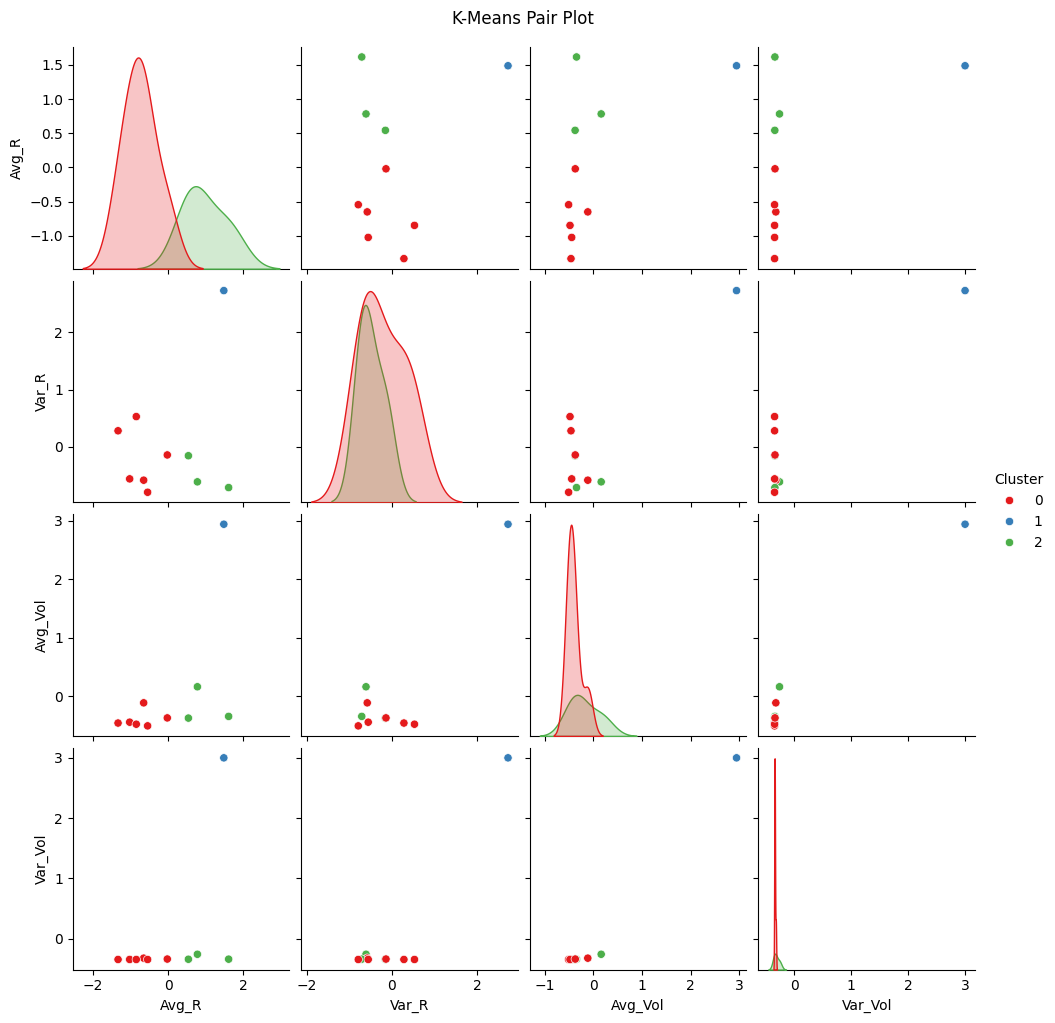

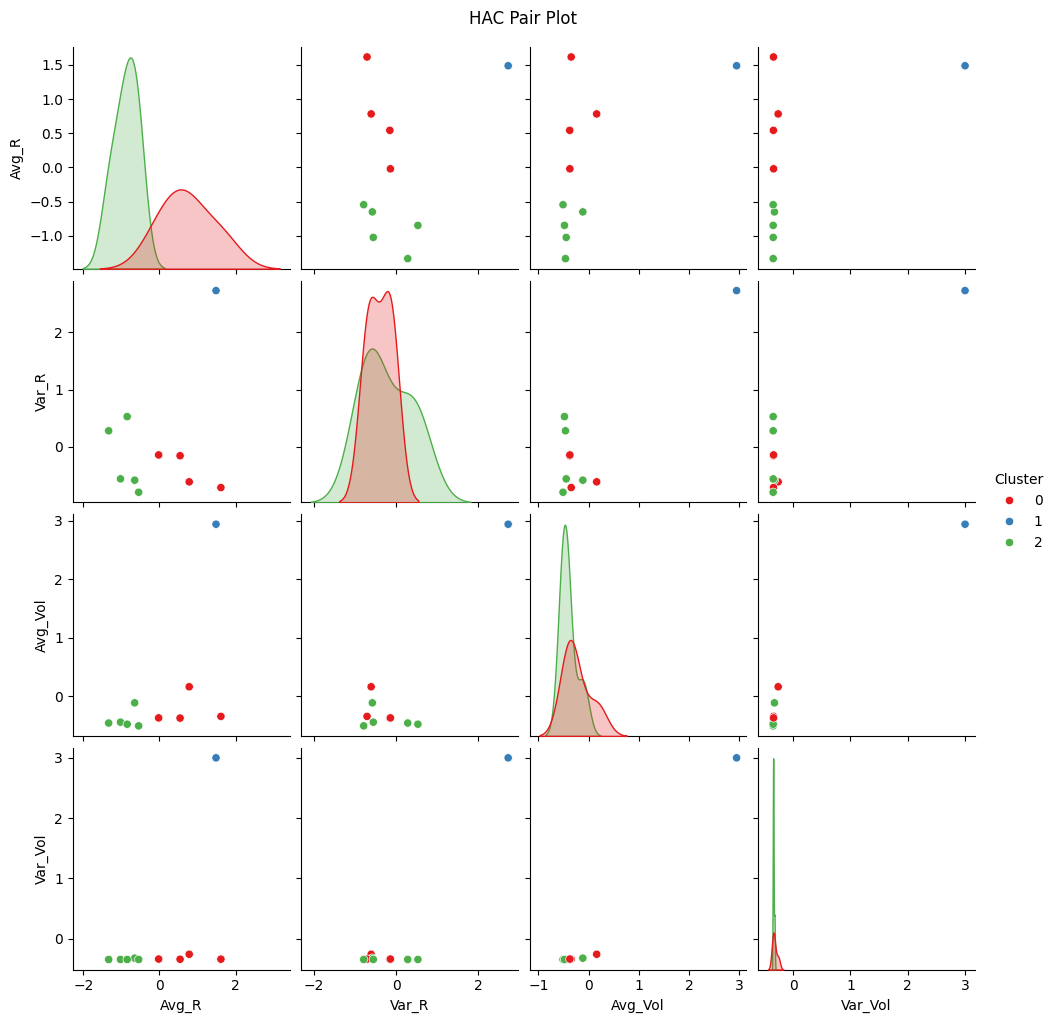

In [72]:
sns.pairplot(k_means_result, hue='Cluster', palette='Set1')
plt.suptitle("K-Means Pair Plot", y=1.02)
plt.show()

sns.pairplot(hac_result, hue='Cluster', palette='Set1')
plt.suptitle("HAC Pair Plot", y=1.02)
plt.show()

### Plot HAC Dendogram

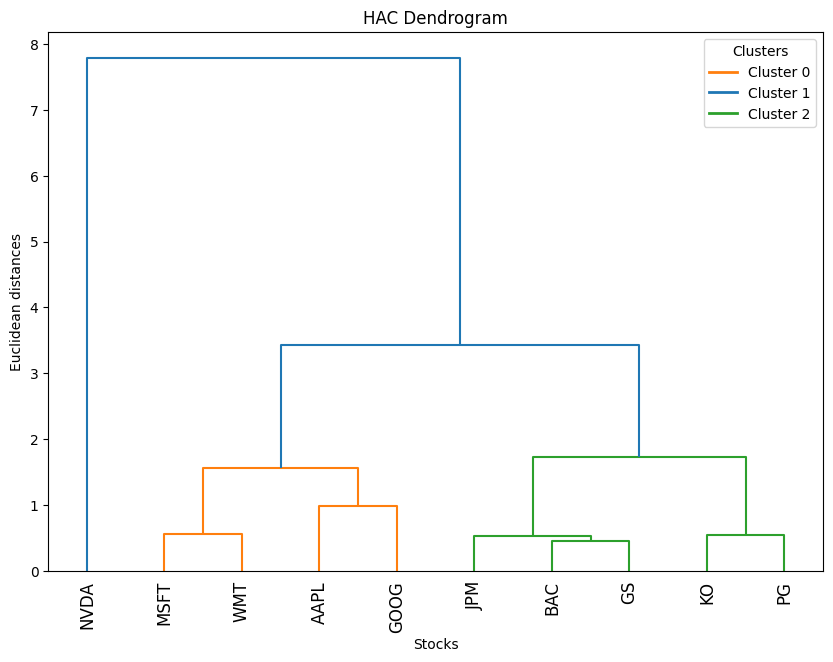

In [73]:
linkage_matrix = linkage(features_scaled, method=optimal_linkage_type)

# Create a legend with colored lines
color_labels = {'C1': 'Cluster 0', 'C0': 'Cluster 1', 'C2': 'Cluster 2',}
legend_lines = [Line2D([0], [0], color=color, lw=2) for color in color_labels.keys()]
legend_labels = color_labels.values()

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=features.index, leaf_rotation=90,color_threshold=2)
plt.legend(legend_lines, legend_labels, loc='upper right', title="Clusters")
plt.title("HAC Dendrogram")
plt.xlabel("Stocks")
plt.ylabel("Euclidean distances")
plt.show()

### Compare Silhouette Scores
From the scores we can reason that K-Means performs better than HAC by a small margin since it has the higher silhouette score

In [74]:
#Compare Silhouette Scores
k_means_silhouette = silhouette_score(k_means_result.drop('Cluster', axis=1), kmeans.labels_)
print("K-Means Silhouette Score:", k_means_silhouette)

hac_silhouette = silhouette_score(hac_result.drop('Cluster',axis=1), hac_labels)
print("HAC Silhouette Score:", hac_silhouette)

K-Means Silhouette Score: 0.40518271994271327
HAC Silhouette Score: 0.37477133571375265


## Define final cluster moving forward

In [75]:
clusters = []
for i, cluster in enumerate(k_means_clusters):
    arr = []
    cluster_names = k_means_clusters[cluster]
    for stock in cluster_names:
        arr.append(asset_lst.index(stock))
    clusters.append(arr)
print(clusters) #this is used in Task 3!

[[0, 2, 6], [1, 3, 4, 5, 8, 9], [7]]


# Task 2. Prediction



In [76]:
start_date_t2 = '2017-01-01' # inclusive
end_date_t2 = '2019-07-01' # exclusive
MyData = yfin.download(asset_lst,start=start_date_t2,end=end_date_t2)

#Computing returns
return_df=MyData['Adj Close'].copy()
for ticker in asset_lst:
    return_df[ticker]=(MyData['Open'][ticker]-MyData['Adj Close'][ticker])/MyData['Open'][ticker]


#Spliting data into training and testing
train_end = '2019-01-01'
test_start = '2019-01-02'
test_end = '2019-06-30'
Return_train_df=return_df.loc[:train_end].copy()
Return_test_df=return_df.loc[test_start:test_end].copy()


[*********************100%***********************]  10 of 10 completed


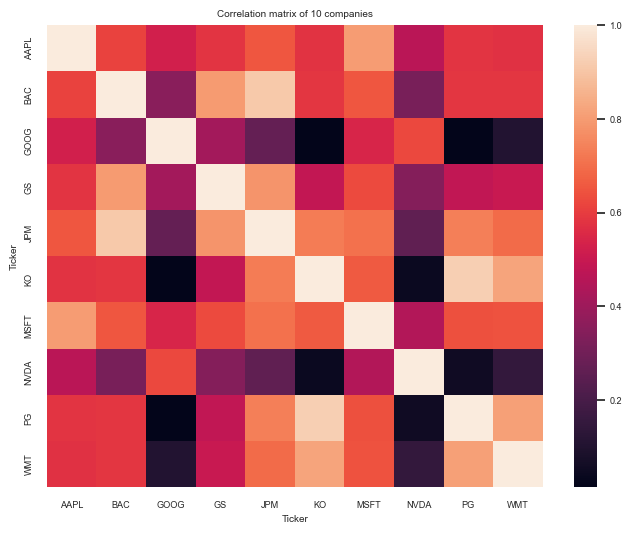

In [77]:
#examining the correlation between the returns on training data
corr_matrix=Return_train_df.corr()

sns.set(font_scale=0.6)
plt.figure(figsize = (8, 6))
sns.heatmap(corr_matrix)
plt.title("Correlation matrix of 10 companies")
plt.show();



In [78]:
#computing clusters based on a correlation distance
#each cluster will have highly correlated returns
#it would be more robust to build a single model for each cluster
dissimilarity = 1.0-corr_matrix #corr=1 means zero distance
hierarchy = linkage(squareform(dissimilarity), method='average') #'average' linkage
#brake into closters with correlation > 1-threshold

threshold=0.3 #seems best, makes into 5 clusters with correlation >0.7
#threshold=0.0 #puts each company into a separate cluster
#threshold=1.0 #puts all companise into a single cluster
labels = fcluster(hierarchy, threshold, criterion='distance')

assets=list(Return_train_df.columns)
print(assets)
print(labels)

#convert labels in a more readable format
clusters_t2={}
for key in range(1,max(labels)+1):
    clusters_t2[key]=[]
#print(assets)
for i,c in enumerate(labels):
    clusters_t2[c].append(assets[i])

print(f'Clusters: {clusters_t2}')

['AAPL', 'BAC', 'GOOG', 'GS', 'JPM', 'KO', 'MSFT', 'NVDA', 'PG', 'WMT']
[4 5 1 5 5 3 4 2 3 3]
Clusters: {1: ['GOOG'], 2: ['NVDA'], 3: ['KO', 'PG', 'WMT'], 4: ['AAPL', 'MSFT'], 5: ['BAC', 'GS', 'JPM']}


In [79]:
#function that creates lagged features and returns (X,y) pair
#for a set of companies in asset_class and a time window (start_date, end_date)

def create_X_y_for_asset_class(data, start_date, end_date, lags, asset_class):
    df=data.loc[start_date:end_date].copy()
    for ticker in asset_class:
        if ticker==asset_class[0]:
            lagged_data=pd.DataFrame({'Returns': df[ticker]})
            for lag in range(1, lags+1):
                lagged_data[f'Lag_{lag}'] = lagged_data['Returns'].shift(lag)
            lagged_data=lagged_data.dropna()
        else:
            lagged_data_tmp=pd.DataFrame({'Returns': df[ticker]})
            for lag in range(1, lags+1):
                lagged_data_tmp[f'Lag_{lag}'] = lagged_data_tmp['Returns'].shift(lag)
            lagged_data_tmp=lagged_data_tmp.dropna()

            lagged_data = pd.concat((lagged_data,lagged_data_tmp), ignore_index = True)
    y = lagged_data['Returns'].values
    X = lagged_data.drop(columns=['Returns']).values

    return (X,y)

In [80]:
#Sliding Window CV code testing different LAG

sliding_window=int(364/2) #1/2 year including all days
#test the model for for a specific 'lag' and 'asset_class' of companies

asset_class=asset_lst #testing the average performance of all 10 companies
asset_class=['JPM','GS','BAC']

lag=10
lam=100
penalty='Ridge' #or 'Lasso'

def MSE_sliding_window_CV(Return_train_df,lag, asset_class, sliding_window, lam, penalty):
    cv_results = {}
    num_assets=len(asset_class)
    mse_list = []
    window_bussines=int(sliding_window*250/364) #includes only business days
    k=int(len(Return_train_df)/window_bussines)-1
    start_date=Return_train_df.index[0]
    for j in range(k):
        start_train=start_date+timedelta(days=sliding_window*j)
        end_train=start_date+timedelta(days=sliding_window*(j+1))
        X_train,y_train=create_X_y_for_asset_class(Return_train_df, start_train, end_train, lag, asset_class)

        start_test=start_date+timedelta(days=sliding_window*(j+1))
        end_test=start_date+timedelta(days=sliding_window*(j+2))
        X_test,y_test=create_X_y_for_asset_class(Return_train_df, start_test, end_test, lag, asset_class)

        if lam==0.0:
            model = LinearRegression(fit_intercept=True)
        else:
            if penalty=='Ridge':
                model=Ridge(alpha=lam,fit_intercept=True,solver='svd')
            elif penalty=='Lasso':
                model=Lasso(alpha=lam,fit_intercept=True)
            else:
                print('No such penalty!')
                return

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)


    avg_mse = np.mean(mse_list)
    return avg_mse

avg_mse=MSE_sliding_window_CV(Return_train_df,lag, asset_class, sliding_window, lam, penalty)

print('lag= ',lag)
print(f"Class = {asset_class}: Average CV MSE for sliding window of {sliding_window} days = {avg_mse:.6f}")

lag=  10
Class = ['JPM', 'GS', 'BAC']: Average CV MSE for sliding window of 182 days = 0.000332


In [81]:

def find_best_model(Return_train_df,sliding_window,asset_class):
    lag_lst=range(1,21)#[1,2,3,4,5,10,20]
    lam_lst=np.arange(0,0.41,0.02) #[0,1,2,3,4,5, 10, 20]
    penalty_lst=['Ridge','Lasso']
    best_rmse=1
    for lag in lag_lst:
        for penalty in penalty_lst:
            for lam in lam_lst:
                avg_mse=MSE_sliding_window_CV(Return_train_df,lag, asset_class, sliding_window,
                                              lam, penalty)
                root_ave_mse=math.sqrt(avg_mse)
                if root_ave_mse<best_rmse:
                    best_rmse=root_ave_mse
                    best_penalty=penalty
                    best_lam=lam
                    best_lag=lag
                    #print('lag= ',lag, 'penalty=',penalty, 'lambda=',lam)
                    #print(f"Average CV RMSE for sliding window of {sliding_window} days = {math.sqrt(avg_mse):.6f}")
    return (best_lag,best_penalty,best_lam,best_rmse)

best_parameters={}
best_train_RMSE={}
for i in range(1,len(clusters_t2)+1):
    asset_class=clusters_t2[i]
    print(f'\nModeling Class = {asset_class}')
    best_lag,best_penalty,best_lam,best_rmse=find_best_model(
        Return_train_df,sliding_window,asset_class)
    best_parameters[i]={'lag': best_lag, 'penalty': best_penalty, 'lambda': best_lam}
    best_train_RMSE[i]=best_rmse
    print('Best lag=',best_lag, '; Best penalty=',best_penalty, '; Best lambda=',best_lam)
    print(f"Best average CV RMSE for sliding window of {sliding_window} days = {best_rmse:.6f}")

print('\nClusters: ', clusters_t2)
print('Best parameters per cluster:\n',best_parameters)
print('Train CV RMSE per cluster:\n', best_train_RMSE)


Modeling Class = ['GOOG']
Best lag= 2 ; Best penalty= Ridge ; Best lambda= 0.0
Best average CV RMSE for sliding window of 182 days = 0.013888

Modeling Class = ['NVDA']
Best lag= 1 ; Best penalty= Ridge ; Best lambda= 0.0
Best average CV RMSE for sliding window of 182 days = 0.023731

Modeling Class = ['KO', 'PG', 'WMT']
Best lag= 18 ; Best penalty= Ridge ; Best lambda= 0.1
Best average CV RMSE for sliding window of 182 days = 0.008689

Modeling Class = ['AAPL', 'MSFT']
Best lag= 13 ; Best penalty= Ridge ; Best lambda= 0.04
Best average CV RMSE for sliding window of 182 days = 0.013373

Modeling Class = ['BAC', 'GS', 'JPM']
Best lag= 17 ; Best penalty= Ridge ; Best lambda= 0.08
Best average CV RMSE for sliding window of 182 days = 0.011530

Clusters:  {1: ['GOOG'], 2: ['NVDA'], 3: ['KO', 'PG', 'WMT'], 4: ['AAPL', 'MSFT'], 5: ['BAC', 'GS', 'JPM']}
Best parameters per cluster:
 {1: {'lag': 2, 'penalty': 'Ridge', 'lambda': 0.0}, 2: {'lag': 1, 'penalty': 'Ridge', 'lambda': 0.0}, 3: {'lag'

In [82]:
#fitting models with best parameters for each cluster
# on the last 6 months of training data 2018-07-02 - 2019-01-01
#and then testing on 2019-01-02 - 2019-06-30

train_end_final=Return_train_df.index[-1]
train_start_final=train_end_final-timedelta(days=sliding_window)

rmse_test_w_best_par={}
for i in range(1,len(clusters_t2)+1):
    print('\nCluster:',clusters_t2[i])
    print('Parameters:', best_parameters[i])
    print('RMSE CV train:\t', best_train_RMSE[i])

    asset_class=clusters_t2[i]
    lag=best_parameters[i]['lag']
    X_train,y_train=create_X_y_for_asset_class(
        Return_train_df,train_start_final, train_end_final, lag, asset_class)

    penalty_final=best_parameters[i]['penalty']
    lambda_final=best_parameters[i]['lambda']

    if lambda_final==0.0:
        model=LinearRegression(fit_intercept=True)
    elif penalty_final=='Ridge':
        model=Ridge(alpha=lambda_final,fit_intercept=True, solver='svd')
    elif penalty=='Lasso':
        model=Lasso(alpha=lambda_final,fit_intercept=True)
    else:
        print('No such penalty!')

    model.fit(X_train, y_train)

    test_start_final=Return_test_df.index[0]
    test_end_final=Return_test_df.index[-1]
    X_test,y_test=create_X_y_for_asset_class(
        Return_test_df,test_start_final, test_end_final, lag, asset_class)

    y_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test=math.sqrt(mse_test)
    print('RMSE test:\t', rmse_test)
    rmse_test_w_best_par[i]={'RMSE test': rmse_test}
    #added relative error
    print('Relative error=',abs(best_train_RMSE[i]-rmse_test)/best_train_RMSE[i])



Cluster: ['GOOG']
Parameters: {'lag': 2, 'penalty': 'Ridge', 'lambda': 0.0}
RMSE CV train:	 0.013888106049123598
RMSE test:	 0.011373537252247856
Relative error= 0.1810591586773218

Cluster: ['NVDA']
Parameters: {'lag': 1, 'penalty': 'Ridge', 'lambda': 0.0}
RMSE CV train:	 0.0237306017372572
RMSE test:	 0.021848636479495004
Relative error= 0.07930541663456846

Cluster: ['KO', 'PG', 'WMT']
Parameters: {'lag': 18, 'penalty': 'Ridge', 'lambda': 0.1}
RMSE CV train:	 0.008688623409794542
RMSE test:	 0.0070767632816499376
Relative error= 0.18551386705603798

Cluster: ['AAPL', 'MSFT']
Parameters: {'lag': 13, 'penalty': 'Ridge', 'lambda': 0.04}
RMSE CV train:	 0.013373116904496161
RMSE test:	 0.01118447175200156
Relative error= 0.16366006280546008

Cluster: ['BAC', 'GS', 'JPM']
Parameters: {'lag': 17, 'penalty': 'Ridge', 'lambda': 0.08}
RMSE CV train:	 0.011529624580649284
RMSE test:	 0.009019007889687356
Relative error= 0.21775355072493996


In [83]:
r_hat=pd.DataFrame(np.zeros((1,10)), columns=Return_test_df.columns,index=[Return_test_df.index[0]])

for i in range(1,len(clusters_t2)+1):
    asset_class=clusters_t2[i]
    lag=best_parameters[i]['lag']
    X_train,y_train=create_X_y_for_asset_class(
        Return_train_df,train_start_final, train_end_final, lag, asset_class)

    penalty_final=best_parameters[i]['penalty']
    lambda_final=best_parameters[i]['lambda']

    if lambda_final==0.0:
        model=LinearRegression(fit_intercept=True)
    elif penalty_final=='Ridge':
        model=Ridge(alpha=lambda_final,fit_intercept=True,solver='svd')
    elif penalty=='Lasso':
        model=Lasso(alpha=lambda_final,fit_intercept=True)
    else:
        print('No penalty!')

    model.fit(X_train, y_train)
    for ticker in clusters_t2[i]:
        X=[Return_train_df[ticker][-lag:].values[::-1]]#the list of lagged returns needs to be reversed
        r_hat[ticker] = model.predict(X)

print('\nr_hat for Jan 2, 2019:\n',r_hat.iloc[0])
print('\nr_actual for Jan 2, 2019:\n', Return_test_df.iloc[0])

print('\nabsolute error=|r_hat-r_actual| for Jan 2, 2019:\n',
      abs(Return_test_df.iloc[0]-r_hat.iloc[0]))

print('\nr hat values:',r_hat.values)


r_hat for Jan 2, 2019:
 Ticker
AAPL    0.059531
BAC     0.141278
GOOG   -0.000591
GS      0.138441
JPM     0.163359
KO      0.172124
MSFT    0.068506
NVDA    0.007769
PG      0.140902
WMT     0.092683
Name: 2019-01-02 00:00:00+00:00, dtype: float64

r_actual for Jan 2, 2019:
 Ticker
AAPL    0.026184
BAC     0.105011
GOOG   -0.025119
GS      0.092438
JPM     0.131376
KO      0.170056
MSFT    0.042586
NVDA   -0.034320
PG      0.137926
WMT     0.073788
Name: 2019-01-02 00:00:00+00:00, dtype: float64

absolute error=|r_hat-r_actual| for Jan 2, 2019:
 Ticker
AAPL    0.033347
BAC     0.036267
GOOG    0.024528
GS      0.046003
JPM     0.031983
KO      0.002068
MSFT    0.025920
NVDA    0.042090
PG      0.002976
WMT     0.018895
Name: 2019-01-02 00:00:00+00:00, dtype: float64

r hat values: [[ 0.05953055  0.14127753 -0.0005913   0.13844108  0.16335907  0.17212395
   0.06850582  0.00776939  0.14090217  0.09268272]]


[*********************100%***********************]  10 of 10 completed


0.006168312152259775
[-0.19444906 -0.20882217]
0.01646529566164613
[-0.39583981]
0.0018013918763561954
[0.0757767  0.06108405 0.07093399 0.03658656 0.07749395 0.04900409
 0.03272027 0.06597244 0.04896454 0.03673614 0.07903656 0.05022156
 0.0576802  0.04732275 0.0224039  0.05096006 0.06772017 0.05126681]
0.02145556783445946
[-0.01546656  0.00803329  0.03650057 -0.01819016  0.09023807  0.04999211
  0.11096295  0.0686822  -0.01412399  0.11097203  0.03983258  0.03439971
  0.1123745 ]
0.020678247525339116
[ 0.09129014  0.07989284  0.02013199  0.03008238  0.01262541  0.07609353
  0.04895722  0.06223267  0.04682577  0.06827147  0.00943072  0.04853618
  0.11318126 -0.00515003  0.0525492   0.03649344  0.06887977]


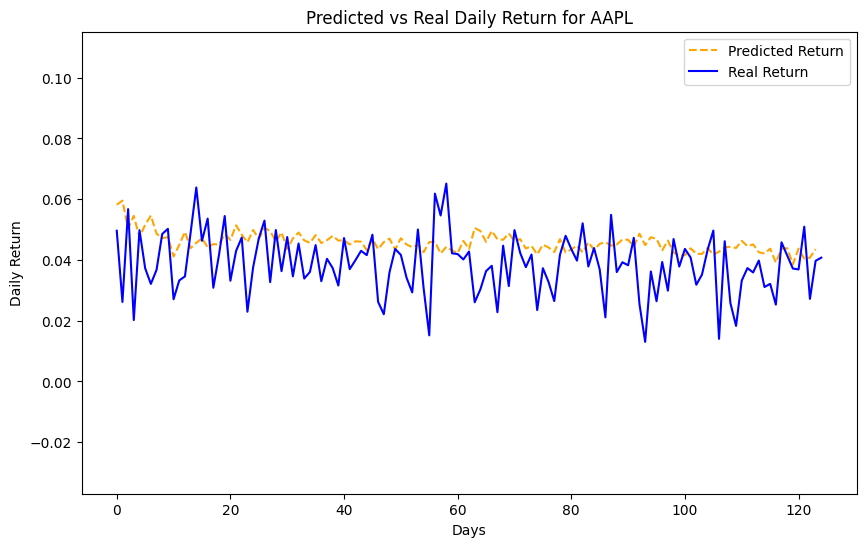

AAPL RMSE: 0.012746486382578717


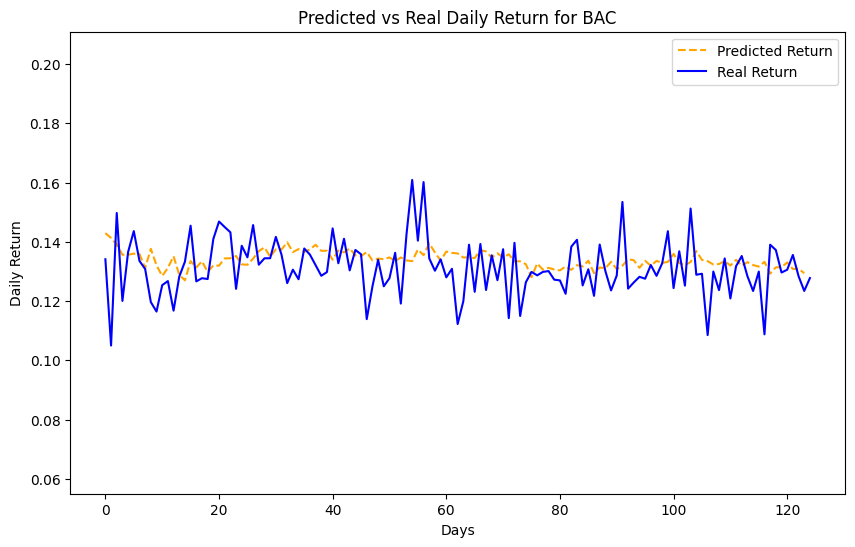

BAC RMSE: 0.010194435791828512


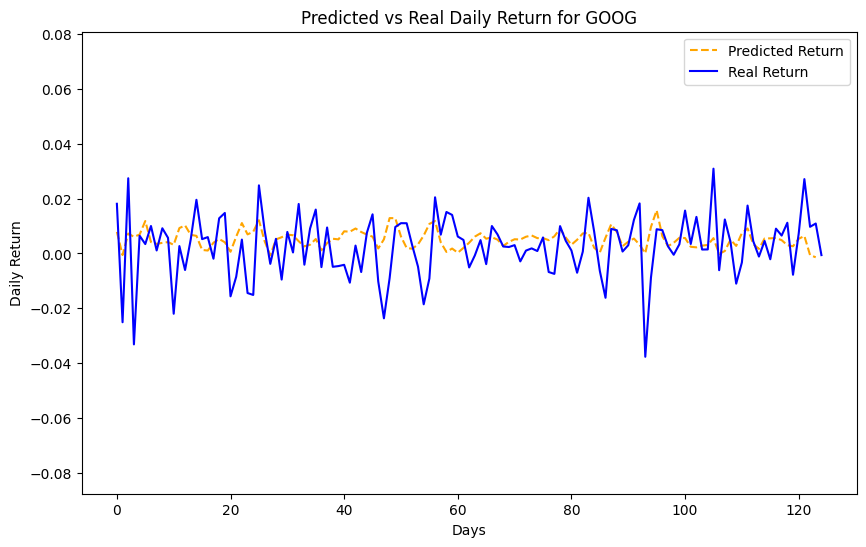

GOOG RMSE: 0.011670557391196965


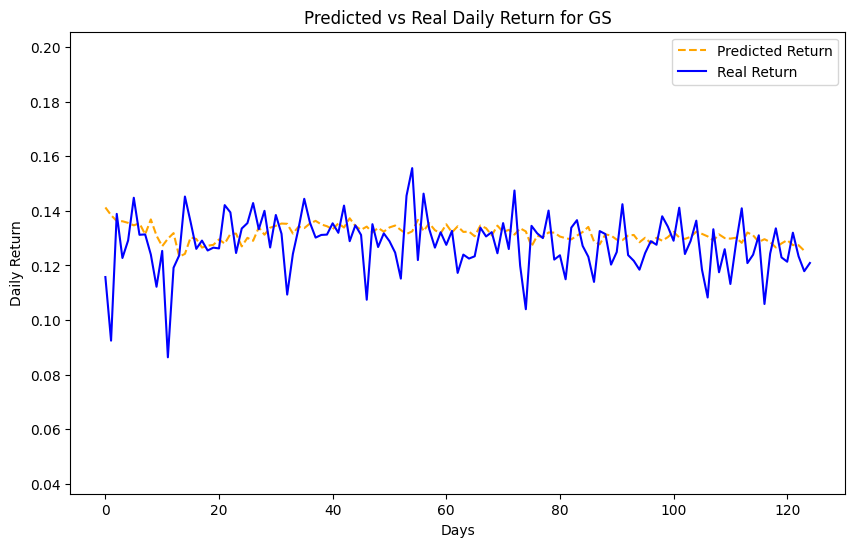

GS RMSE: 0.011547700934839955


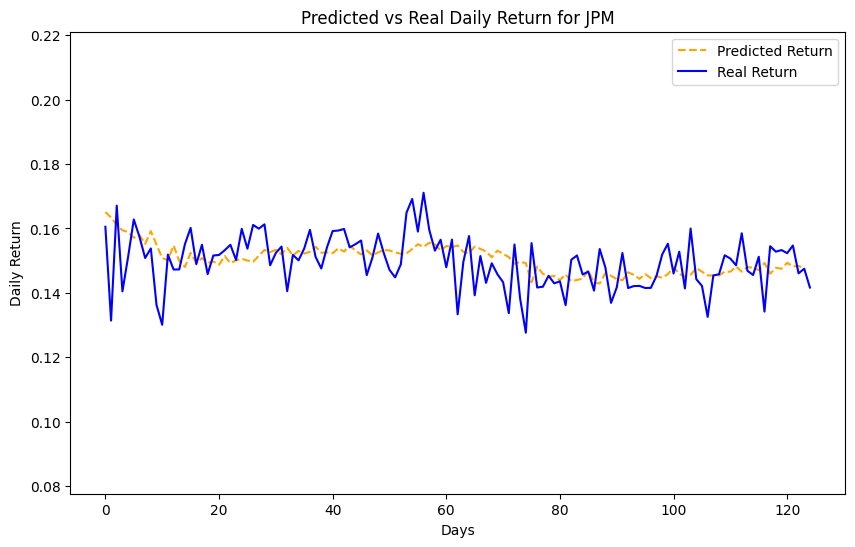

JPM RMSE: 0.008175175587099015


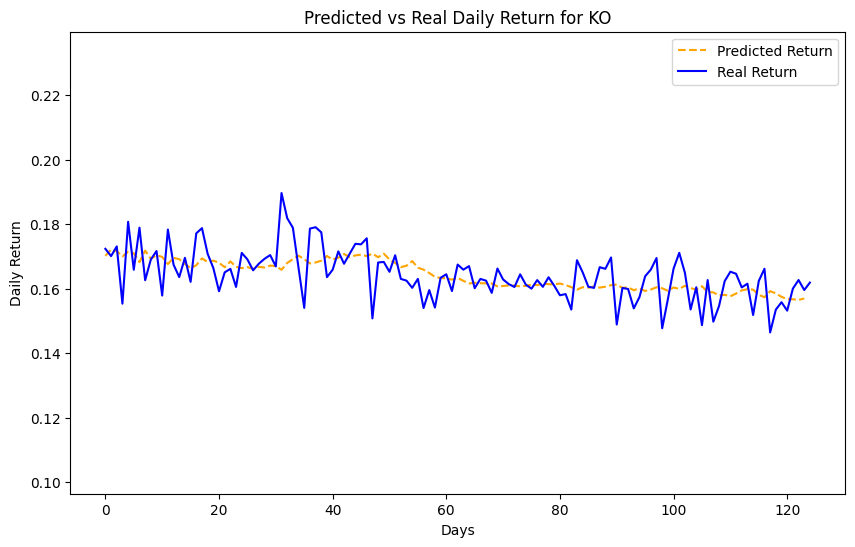

KO RMSE: 0.006677006284538635


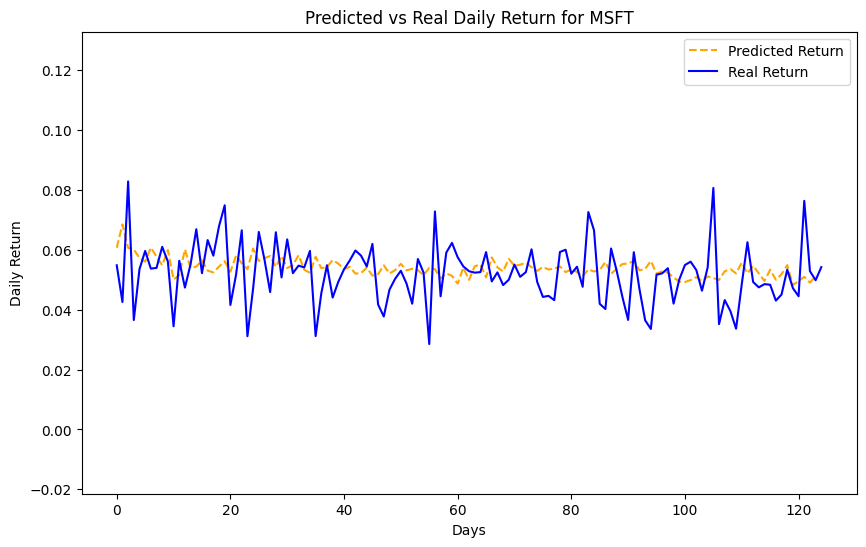

MSFT RMSE: 0.010544427992065949


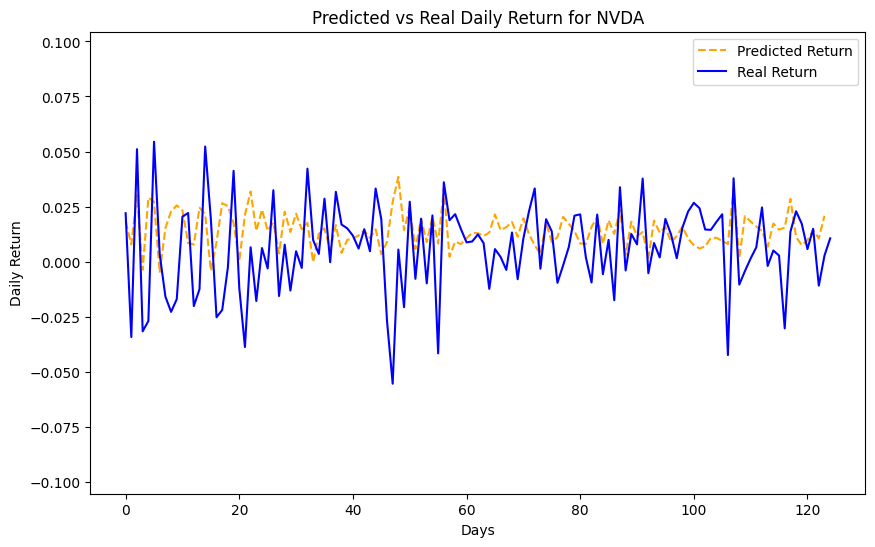

NVDA RMSE: 0.02208447866651035


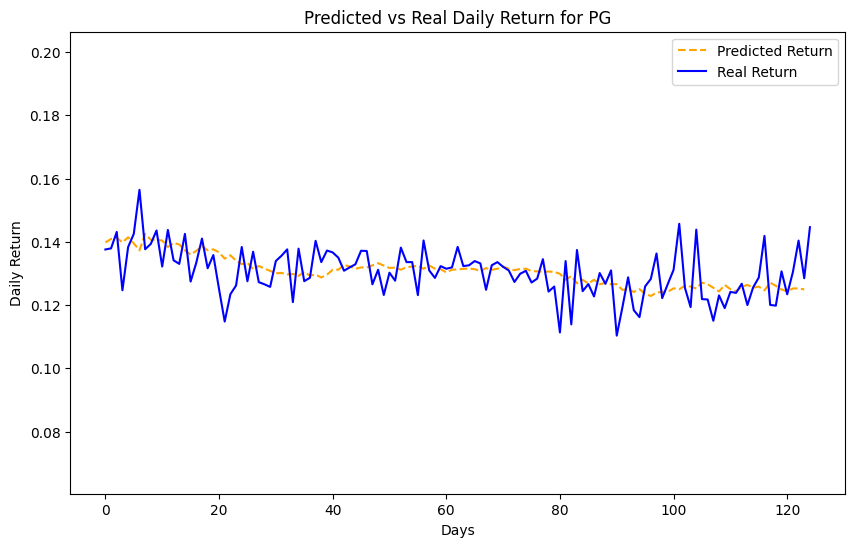

PG RMSE: 0.007127242175153762


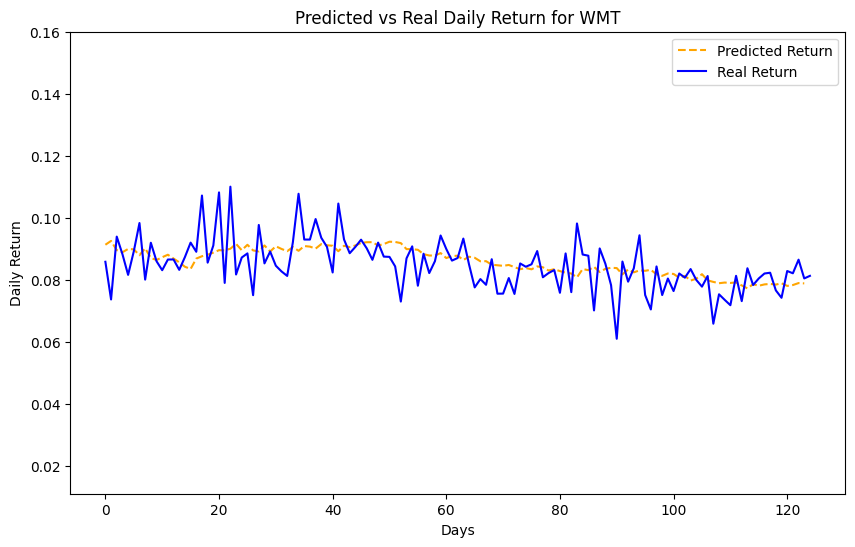

WMT RMSE: 0.007496454108263847


In [84]:
def rolling_predictions(initial_data, real_returns, start, num_days):
    return_pred = {ticker: [] for ticker in initial_data.columns}
    predictions = []
    actual_returns = {ticker: [] for ticker in initial_data.columns}

    for cluster_idx in range(1,len(clusters_t2)+1):  # Iterate over clusters
        asset_class=clusters_t2[cluster_idx]
        lag = best_parameters[cluster_idx]['lag']
        #print('cluseter:',cluster_idx,'lag=',lag,asset_class)
        X_train, y_train = create_X_y_for_asset_class(
            Return_train_df, train_start_final, train_end_final, lag, asset_class
        )

        penalty_final = best_parameters[cluster_idx]['penalty']
        lambda_final = best_parameters[cluster_idx]['lambda']

        #print('penalty=',penalty_final,'lambda=',lambda_final )

        if lambda_final == 0.0:
            model = LinearRegression(fit_intercept=True)
        elif penalty_final == 'Ridge':
            model = Ridge(alpha=lambda_final, fit_intercept=True, solver='svd')
        elif penalty_final == 'Lasso':
            model = Lasso(alpha=lambda_final, fit_intercept=True)
        else:
            raise ValueError('Invalid penalty type!')

        model.fit(X_train, y_train)

        print(model.intercept_)
        print(model.coef_)

        # Iterate over stock and time
        for ticker in asset_class:
            for day in range(num_days):
                #the list of lagged returns needs to be reversed
                X = [real_returns[ticker].iloc[start + day - lag : start + day].values[::-1]]
                predicted = model.predict(X)
                return_pred[ticker].append(predicted[0])
                actual_return = real_returns[ticker].iloc[start + day]
                actual_returns[ticker].append(actual_return)

    predictions_df = pd.DataFrame.from_dict(return_pred, orient='index').T
    return return_pred, predictions_df, actual_returns


start_date_total = '2016-01-01'  # inclusive
end_date_total = '2019-06-30'  # exclusive

MyData_t3 = yfin.download(asset_lst, start=start_date_total, end=end_date_total)
MyData_t3 = MyData_t3.dropna()
full_returns_df=MyData_t3['Adj Close'].copy()
for ticker in asset_lst:
    full_returns_df[ticker]=(MyData_t3['Open'][ticker]-MyData_t3['Adj Close'][ticker])/MyData_t3['Open'][ticker]


# Get the predicted returns and the actual returns for comparison
return_pred, predictions, actual_returns = rolling_predictions(full_returns_df,
                                                               full_returns_df, 753, num_days=124)

# Plot the predicted vs real returns for each stock
for stock in asset_lst:
    plt.figure(figsize=(10, 6))

    predicted_values = return_pred[stock]
    actual_values = full_returns_df[stock][753:].values
    max_y=max(max(actual_values),max(predicted_values))
    min_y=min(min(actual_values),min(predicted_values))
    plt.rcdefaults()
    plt.ylim(min_y-.05, max_y+.05)
    plt.plot(predicted_values, label='Predicted Return', linestyle='--', color='orange')
    plt.plot(actual_values, label='Real Return', color='blue')
    plt.title(f"Predicted vs Real Daily Return for {stock}")
    plt.xlabel('Days')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.show()

    rmse = np.mean((np.array(predicted_values) - np.array(actual_values[:-1]))**2)**(1/2)
    print(f"{stock} RMSE: {rmse}")

# Task 3. Portfolio Optimization



In [85]:
r_hat = [] #predicted returns on Jan 2
r_hat2 = [] #predicted returns on Jan 3
for stock in return_pred:
    r_hat.append(return_pred[stock][0])
    r_hat2.append(return_pred[stock][1])
    
start_date_t3 = '2017-01-01'  # inclusive
end_date_t3 = '2019-01-01'  # exclusive
MyData_t3 = yfin.download(asset_lst, start=start_date_t3, end=end_date_t3)
MyData_adj_close = MyData_t3['Adj Close']
MyData_open = MyData_t3['Open']
cov_matrix_t3 = ((MyData_adj_close - MyData_open) / MyData_open).dropna().cov()
    

[*********************100%***********************]  10 of 10 completed


## Alternating PGD Method

In [86]:
#simplex projection algorithm to project weight vector into valid space where x_i ≥ 0 and weights sum to 1
def simplex_projection(x):
    n = len(x)
    sorted_x = np.sort(x)[::-1]
    cumulative_sum = np.cumsum(sorted_x)
    rho = np.max(np.where(sorted_x > (cumulative_sum - 1) / np.arange(1, n + 1)))
    threshold = (cumulative_sum[rho] - 1) / (rho + 1)
    return np.maximum(x - threshold, 0)

#projects weight vector into valid cluster constraint by proportionally scaling cluster weights down if they sum to greater than 0.5
def cluster_projection(x, clusters):
    for cluster in clusters:
        cluster_sum = np.sum(x[cluster])
        if cluster_sum > 0.5:
            excess = cluster_sum - 0.5
            x[cluster] -= excess * (x[cluster] / cluster_sum)
    return x

#projects weight vector into valid turnover constraint space by clipping differences to stay within 0.1 of x_0
def turnover_projection(x, x_0):
    return np.clip(x, x_0 - 0.1, x_0 + 0.1)

#Checks all the contraints (turnover constraint as well if flag is true)
def check_constraints(x, clusters, x_0=None, turnover_constraint=False):
    if np.any(x < 0) or not np.isclose(np.sum(x), 1, atol=1e-6):
        return False
    for cluster in clusters:
        if np.sum(x[cluster]) > 0.5:
            return False
    if turnover_constraint and x_0 is not None:
        if np.any(np.abs(x - x_0) > 0.1):
            return False
    return True

# Iterative Projection (can include turnover_constraint when x_0 is given and turnover_constraint=True)
def iterative_projection(x, clusters, x_0=None, turnover_constraint=False, max_iter=1000):
    for _ in range(max_iter):
        prev_x = x.copy()
        x = simplex_projection(x)
        x = cluster_projection(x, clusters)
        if turnover_constraint and x_0 is not None:
            x = turnover_projection(x, x_0)
        if np.linalg.norm(x - prev_x) < 1e-5 and check_constraints(x, clusters, x_0, turnover_constraint):
            break
    return x

# Gradient Descent (Customizable for Turnover)
def pgd_gradient_descent(cov_matrix, predicted_returns, clusters, lambda_val=0.1, x_0=None, turnover_constraint=False, max_iter=1000, tol=1e-6, alpha=0.01):
    n_assets = len(predicted_returns)
    weights = np.ones(n_assets) / n_assets  # Initialize with equal weights
    obj_prev = -np.inf

    for iteration in range(max_iter):
        grad = predicted_returns - 2 * lambda_val * cov_matrix @ weights
        weights += alpha * grad
        weights = iterative_projection(weights, clusters, x_0, turnover_constraint)

        # Calculate objective
        obj = predicted_returns @ weights - lambda_val * weights @ cov_matrix @ weights

        if abs(obj - obj_prev) < tol:
            print(f"Converged after {iteration} iterations with objective: {obj}")
            break

        obj_prev = obj

    return weights

## Penalty Method

In [87]:
def penalty_function(x, clusters, x_0=None, turnover_constraint=False, lambda_pen=1000.0):
    penalty = 0.0
    penalty += lambda_pen * (np.sum(x) - 1.0)**2 # weights sum-to-one penalty
    penalty += lambda_pen * np.sum(np.maximum(-x, 0)**2) # x_i ≥ 0 penalty

    for cluster in clusters:
        cluster_sum = np.sum(x[cluster])
        if cluster_sum > 0.5:
            penalty += lambda_pen * (cluster_sum - 0.5)**2 #adds penalty for each cluster

    # adds turnover constraint penalty if needed
    if turnover_constraint and x_0 is not None:
        diff = np.abs(x - x_0) - 0.1
        diff = np.maximum(diff, 0)
        penalty += lambda_pen * np.sum(diff**2)

    return penalty

def penalty_gradient(x, clusters, x_0=None, turnover_constraint=False, lambda_pen=1000.0):
    grad = np.zeros_like(x)
    grad += 2 * lambda_pen * (np.sum(x) - 1) #sum to one gradient

    negative_idx = x < 0
    grad[negative_idx] += 2 * lambda_pen * x[negative_idx] # x_i ≥ 0 gradient

    for cluster in clusters:
        cluster_sum = np.sum(x[cluster])
        if cluster_sum > 0.5:
            grad[cluster] += 2 * lambda_pen * (cluster_sum - 0.5) # cluster gradient for each cluster

    if turnover_constraint and x_0 is not None:
        diff = np.abs(x - x_0) - 0.1
        outside = diff > 0
        sign = np.sign(x - x_0)
        grad[outside] += 2 * lambda_pen * diff[outside] * sign[outside] #adds turnover gradient if necessary

    return grad

def penalty_gradient_descent(cov_matrix, predicted_returns, clusters, theta=0.1, x_0=None,
                             turnover_constraint=False, max_iter=1000, tol=1e-6, alpha=0.01, lambda_pen=1000.0):
    n_assets = len(predicted_returns)
    weights = np.ones(n_assets) / n_assets
    obj_prev = -np.inf

    for iteration in range(max_iter):
        penalty_val = penalty_function(weights, clusters, x_0, turnover_constraint, lambda_pen)
        obj = predicted_returns @ weights - theta * (weights @ cov_matrix @ weights) - penalty_val

        if np.abs(obj - obj_prev) < tol:
            print(f"Converged after {iteration} iterations with objective: {obj}")
            break
        obj_prev = obj
        grad_obj = predicted_returns - 2 * theta * cov_matrix @ weights #compute objective function gradient
        grad_pen = penalty_gradient(weights, clusters, x_0, turnover_constraint, lambda_pen) #compute penalty function gradient
        grad = grad_obj - grad_pen
        weights += alpha * grad #gradient ascent step

    return weights


## SciPy Implementation for Baseline

In [88]:
from scipy.optimize import minimize #we only used this here for a baseline xoxo

def scipy_optimize(r_hat, cov_matrix, clusters, theta, x_0=None, turnover_constraint=False):

    n_assets = len(r_hat)

    # Objective function (negative of the utility function to minimize)
    def objective(x):
        return -(r_hat @ x - theta * x @ cov_matrix @ x)

    constraints = []

    #weights must sum to 1
    constraints.append({
        'type': 'eq',
        'fun': lambda x: np.sum(x) - 1
    })

    #weights must be >= 0
    bounds = [(0, None) for _ in range(n_assets)]

    #sum of weights in each cluster must be less than 0.5
    for cluster in clusters:
        constraints.append({
            'type': 'ineq',
            'fun': lambda x, cluster=cluster: 0.5 - np.sum(x[cluster])
        })

    #weights for each stock must not deviate by more than 0.1 from x_0
    if turnover_constraint and x_0 is not None:
        for i in range(n_assets):
            constraints.append({
                'type': 'ineq',
                'fun': lambda x, i=i: x[i] - (x_0[i] - 0.1)
            })
            constraints.append({
                'type': 'ineq',
                'fun': lambda x, i=i: (x_0[i] + 0.1) - x[i]
            })

    x_init = np.ones(n_assets) / n_assets #equal weight initialization

    # Solve optimization problem
    result = minimize(
        objective,
        x_init,
        bounds=bounds,
        constraints=constraints,
        method='SLSQP',
        options={'disp': True}
    )

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    return result.x

## Task 3.1

### Testing Penalty

In [89]:
print(f'Clusters:{clusters}')
print(f'r_hat:{r_hat}')

weights_penalty = penalty_gradient_descent(cov_matrix_t3, r_hat, clusters, theta=1000,alpha=.00001,lambda_pen=300)

# Output results
print(f"Optimized weights:\n{weights_penalty}\n")
print(f"Sum of weights: {np.sum(weights_penalty)}")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: Total weight = {np.sum(weights_penalty[cluster])}")

Clusters:[[0, 2, 6], [1, 3, 4, 5, 8, 9], [7]]
r_hat:[0.05818657195271225, 0.14291380116714736, 0.007877772294847383, 0.14126339391943446, 0.16510407160562507, 0.17013902223295124, 0.06071311520561302, 0.018187449569795042, 0.1397727429796521, 0.09144400256247662]
Converged after 534 iterations with objective: -0.040852948010580335
Optimized weights:
Ticker
AAPL    0.124876
BAC     0.083481
GOOG    0.125092
GS      0.083630
JPM     0.083529
KO      0.083469
MSFT    0.124618
NVDA    0.124324
PG      0.083231
WMT     0.083154
dtype: float64

Sum of weights: 0.9994034552680674
Cluster 0: Total weight = 0.37458602756179804
Cluster 1: Total weight = 0.5004933718611037
Cluster 2: Total weight = 0.12432405584516576


### Testing Alternating PGD

In [90]:
print(f'Clusters:{clusters}')
print(f'r_hat:{r_hat}')

weights_pgd = pgd_gradient_descent(cov_matrix_t3, r_hat, clusters, lambda_val=1000)

# Output results
print(f"Optimized weights:\n{weights_pgd}\n")
print(f"Sum of weights: {np.sum(weights_pgd)}")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: Total weight = {np.sum(weights_pgd[cluster])}")

Clusters:[[0, 2, 6], [1, 3, 4, 5, 8, 9], [7]]
r_hat:[0.05818657195271225, 0.14291380116714736, 0.007877772294847383, 0.14126339391943446, 0.16510407160562507, 0.17013902223295124, 0.06071311520561302, 0.018187449569795042, 0.1397727429796521, 0.09144400256247662]
Converged after 563 iterations with objective: -0.01797317513749759
Optimized weights:
Ticker
AAPL    0.181420
BAC     0.085963
GOOG    0.317518
GS      0.106217
JPM     0.098451
KO      0.099522
MSFT    0.000530
NVDA    0.000530
PG      0.062415
WMT     0.047432
dtype: float64

Sum of weights: 0.9999972272006289
Cluster 0: Total weight = 0.49946716771464145
Cluster 1: Total weight = 0.5
Cluster 2: Total weight = 0.000530059485987344


## Comparing Objective Values

In [91]:
scipy_weights = scipy_optimize(r_hat, cov_matrix_t3, clusters, theta=1000)

def objective(weights,predicted_returns,theta,cov_matrix):
        """Calculates the objective function value."""
        return predicted_returns @ weights - theta * weights @ cov_matrix @ weights

print(f'\nPenalty Objective: {objective(weights_penalty,r_hat,1000,cov_matrix_t3)}')
print(f'PGD Objective: {objective(weights_pgd,r_hat,1000,cov_matrix_t3)}')
print(f'SciPy Objective: {objective(scipy_weights,r_hat,1000,cov_matrix_t3)}')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.011413292210657941
            Iterations: 11
            Function evaluations: 121
            Gradient evaluations: 11

Penalty Objective: -0.040673163587422706
PGD Objective: -0.01797317513749759
SciPy Objective: -0.011413292210657941


### Run PGD for multiple values from lambda

In [92]:
lambdas = np.logspace(-1,4,5)
final_weights = {}
for lambda_val in lambdas:
    final_weights[lambda_val] = pgd_gradient_descent(cov_matrix_t3, r_hat, clusters, lambda_val)
    
df = pd.DataFrame(final_weights)
objective_values = [objective(final_weights[i],r_hat,i,cov_matrix_t3) for i in final_weights.keys()]
display(df)

print(f'Objective Values for each lambda:{objective_values}')

Converged after 787 iterations with objective: 0.10439640873399243
Converged after 789 iterations with objective: 0.10413711829724215
Converged after 790 iterations with objective: 0.0995120961191135
Converged after 984 iterations with objective: 0.0281198649081153
Converged after 173 iterations with objective: -0.8974659788822742


,0.100000,1.778279,31.622777,562.341325,10000.000000
Ticker,,,,,
AAPL,0.239571,0.239912,0.246348,0.233681,0.022771
BAC,0.084458,0.084507,0.085345,0.088032,0.057450
GOOG,0.000493,0.000493,0.000496,0.239551,0.475418
GS,0.082839,0.082951,0.084900,0.100193,0.137261
JPM,0.106269,0.106278,0.106210,0.101703,0.055861
KO,0.111214,0.111142,0.109628,0.099619,0.106154
MSFT,0.259436,0.259094,0.252652,0.026198,0.000902
NVDA,0.000493,0.000493,0.000496,0.000567,0.000902
PG,0.081361,0.081264,0.079587,0.066973,0.045898


Objective Values for each lambda:[0.10439640873399243, 0.10413711829724215, 0.0995120961191135, 0.0281198649081153, -0.8974659788822742]


## Task 3.2

In [93]:
selected_lambda = 562.341325190349
x_0 = np.array(final_weights[selected_lambda])

weights2 = pgd_gradient_descent(cov_matrix_t3, r_hat2, clusters,selected_lambda,x_0,turnover_constraint=True)
print(weights2,'\n')
print(f'Clusters:{clusters}')
print(f'All weights sum to {np.sum(weights2)}')
for i, cluster in enumerate(clusters):
    print(f'Cluster {i}:{np.sum(weights2[cluster])}')

Converged after 492 iterations with objective: 0.025955905940340834
Ticker
AAPL    0.213073
BAC     0.089036
GOOG    0.188985
GS      0.101441
JPM     0.101830
KO      0.099762
MSFT    0.097399
NVDA    0.000541
PG      0.065153
WMT     0.042777
dtype: float64 

Clusters:[[0, 2, 6], [1, 3, 4, 5, 8, 9], [7]]
All weights sum to 0.999997170876988
Cluster 0:0.4994563443371879
Cluster 1:0.5
Cluster 2:0.0005408265398002321


## Task 4: Optimal Multi-Day Trading Strategy Using Dynamic Programming





In [94]:
start_date = '2017-01-01' # inclusive
end_date = '2019-01-02' # exclusive

MyData = yfin.download(['GS'],start=start_date,end=end_date)
MyData = MyData.dropna()

prices = MyData['Open']
volumes = MyData['Volume']

prices = np.round(prices, 2) #round all prices to two decimal places

[*********************100%***********************]  1 of 1 completed


# Naive version of DP
### $O (days \times max\_ inventory\times max(vol_{day}))$

# Dynamic Programming Formula

The DP table is represented as $\text{dp}[d][i]$, where:
* $d$: The day.
* $i$: The inventory level.
* $\text{dp}[d][i] = (\text{value}, \text{quantity})$:
  * $\text{value}$: The maximum cash achievable up to day $d$ with $i$ units of inventory.
  * $\text{quantity}$: The optimal trade quantity made on day $d$ to reach this state.

In [95]:
#initializing values
initial_cash = 100000000.0
max_trading_volume = np.array(volumes) * 0.001
max_inventory = 100 #testing naive DP using small max inventory
days = 8
prices = np.array(prices, dtype=np.float64)

In [96]:
dtype = np.dtype([('value', 'f8'), ('quantity', 'i4')])
dp = np.full((days, max_inventory + 1),
             fill_value=np.array((-np.inf, 0), dtype=dtype),
             dtype=dtype)

initial_positions = int(min(max_trading_volume[0], max_inventory))
for i in range(initial_positions + 1):
    dp[0][i] = (initial_cash - i * prices[0], i)

for day in range(1, days):
    temp = np.full(max_inventory + 1,
                   fill_value=np.array((-np.inf, 0), dtype=dtype),
                   dtype=dtype)

    day_vol = int(max_trading_volume[day])

    for prev_assets in range(max_inventory + 1):
        prev_val = dp[day - 1][prev_assets]['value']
        if prev_val == -np.inf:
            continue

        # q in [-day_vol, day_vol], & respecting inventory limits.
        max_sell = min(prev_assets, day_vol)
        max_buy = min(day_vol, max_inventory - prev_assets)

        for q in range(-max_sell, max_buy + 1):
            fi = prev_assets + q
            if 0 <= fi <= max_inventory:
                # Making a trade of q units at prices[day]
                # If q > 0, we buy q units => cost q * prices[day]
                # If q < 0, we sell -q (same as buy q) units => gain (-q) * prices[day]
                candidate_value = prev_val - q * prices[day]

                ##if candidate_value > temp[fi]['value']:
                if candidate_value >= 0 and candidate_value > temp[fi]['value']: # Didn't test yet, shouldn't change anything
                    temp[fi] = (candidate_value, q)

    dp[day] = temp

final_values = dp[days - 1]['value']

best_final_value = np.max(final_values)
best_inv = np.argmax(final_values)

strat = []
opt_inv = best_inv
for day in range(days - 1, -1, -1):
    q = dp[day][opt_inv]['quantity']
    strat.append(q)
    opt_inv = opt_inv - q

strat.reverse()

cash = initial_cash
inventory = 0
for day, q in enumerate(strat):
    inventory += q
    cash -= q * prices[day]
    print(f"Day {day}: Trade {q}, Inventory {inventory}, Cash {cash}, Price {prices[day]}")

assert np.isclose(cash, best_final_value), f"Mismatch in final wealth: {cash} != {best_final_value}"

print("Strategy (units per day):", strat)
print("Best Final Wealth:", best_final_value)


Day 0: Trade 0, Inventory 0, Cash 100000000.0, Price 242.7
Day 1: Trade 100, Inventory 100, Cash 99975856.0, Price 241.44
Day 2: Trade -100, Inventory 0, Cash 100000128.0, Price 242.72
Day 3: Trade 100, Inventory 100, Cash 99975899.0, Price 242.29
Day 4: Trade -100, Inventory 0, Cash 100000224.0, Price 243.25
Day 5: Trade 100, Inventory 100, Cash 99976137.0, Price 240.87
Day 6: Trade 0, Inventory 100, Cash 99976137.0, Price 242.77
Day 7: Trade -100, Inventory 0, Cash 100000643.0, Price 245.06
Strategy (units per day): [0, 100, -100, 100, -100, 100, 0, -100]
Best Final Wealth: 100000643.0


## Vectorization w/ Segment Tree

## $$O (days \times max\_ inventory\times log(max\_ inventory))$$

Although this approach has a larger worst-case runtime complexity than a naive algorithm, the efficiency of NumPys vectorized operations compensates for this drawback.



## Vectorization:

The vectorization part computes $A[j] = dp[day-1][j] + j * price$ efficiently for all inventory levels $j$ at once using NumPy.

* $j\_ arr$ is a range of inventory levels.
* $prev\_ dp\_ values$ contains the max cash from the previous day.
* $j\_ arr * price$ calculates the value of holding $j$ units at the current price.


## Segment trees:

We use the segment tree to find the maximum $A[j]$ and its index for a range $[ j_{min}, j_{max} ]$

#### Representation
The Segment Tree is represented as a binary tree, where:

*   Each leaf node represents an element of the input array.
*   Each internal node represents the maximum value (or any aggregate value depending on the problem) of its child nodes.

#### Representation in code
The tree is stored in a flat array to minimize space overhead and improve cache efficiency:


*   The root is stored at index 1.
*   The left child of a node at index $i$ is stored at index $2i$.
*   The right child of a node at index $i$ is stored at index $2i+1$.

#### How the tree is built
The tree is built in two steps:

*   Initialize the leaf nodes with values from the input array.
*   Compute values for internal nodes by aggregating the values of their children:
    *   tree$[i]$ = $\max(\text{tree}[2i], \text{tree}[2i+1])$

##### Querying the tree:

To query the maximum value in a range $[L, R]$, the tree is traversed starting from the root:

*   Adjust the range $[L, R]$ to match the indices of the tree array.
*   Traverse the range while checking both left and right segments. Move up the tree after processing.


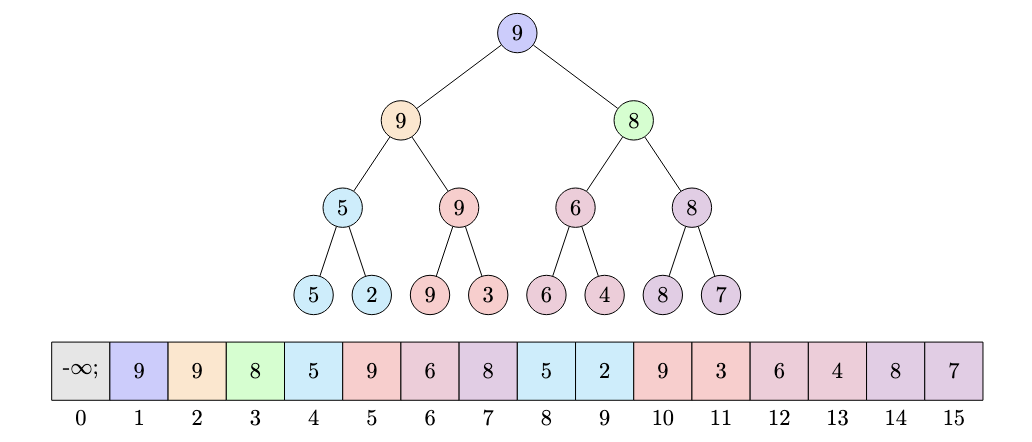

In [97]:
class SegmentTree:
    def __init__(self, arr):
        self.n = len(arr)
        self.size = 1
        while self.size < self.n:
            self.size <<= 1
        self.tree = np.full(self.size * 2, -np.inf, dtype=np.float64)
        self.index_tree = np.full(self.size * 2, -1, dtype=np.int64)
        self._build(arr)

    def _build(self, arr):
        for i in range(self.n):
            self.tree[self.size + i] = arr[i]
            self.index_tree[self.size + i] = i
        for i in range(self.size - 1, 0, -1):
            if self.tree[i * 2] >= self.tree[i * 2 + 1]:
                self.tree[i] = self.tree[i * 2]
                self.index_tree[i] = self.index_tree[i * 2]
            else:
                self.tree[i] = self.tree[i * 2 + 1]
                self.index_tree[i] = self.index_tree[i * 2 + 1]

    def query(self, left, right):
      left = int(left)
      right = int(right)
      left += self.size
      right += self.size
      res = -np.inf
      res_index = -1
      while left <= right:
          if (left & 1) == 1:
              if self.tree[left] > res:
                  res = self.tree[left]
                  res_index = self.index_tree[left]
              left += 1
          if (right & 1) == 0:
              if self.tree[right] > res:
                  res = self.tree[right]
                  res_index = self.index_tree[right]
              right -= 1
          left //= 2
          right //= 2
      return res, res_index


def run_dp_with_segment_tree_and_strategy(days, prices, max_trading_volume, max_inventory, initial_cash):
    dtype = np.dtype([('value', 'f8'), ('quantity', 'i4')])
    dp = np.full((days, max_inventory + 1),
                 fill_value=np.array((-np.inf, 0), dtype=dtype),
                 dtype=dtype)

    initial_positions = min(max_trading_volume[0], max_inventory)
    for inv in range(int(initial_positions) + 1):
        dp[0][inv] = (initial_cash - inv * prices[0], inv)

    for day in range(1, days):
        price = prices[day]
        day_vol = max_trading_volume[day]
        prev_dp_values = dp[day - 1]['value']

        # A[j] = dp[i-1][j] + j * price
        j_arr = np.arange(max_inventory + 1, dtype=np.float32)
        A = prev_dp_values + j_arr * price

        segt = SegmentTree(A)

        for fi in range(max_inventory + 1):
            # Feasible j range based on q in [-day_vol, day_vol]
            j_min = max(0, fi - day_vol)
            j_max = min(max_inventory, fi + day_vol)

            if j_min <= j_max:
                best_value, best_index = segt.query(j_min, j_max)
                if best_value != -np.inf:
                    q = fi - best_index  # Quantity traded
                    candidate_value = best_value - fi * price
                    remaining_cash = best_value - q * price  # Calculate remaining cash
                    if remaining_cash >= 0:  # Ensure non-negative cash
                        dp[day][fi] = (candidate_value, q)

    final_values = dp[days - 1]['value']
    best_final_value = np.max(final_values)
    best_inv = np.argmax(final_values)

    strat = []
    opt_inv = best_inv
    total_cash = dp[days - 1][opt_inv]['value']
    for day in range(days - 1, -1, -1):
        q = dp[day][opt_inv]['quantity']
        strat.append(q)
        opt_inv -= q

    strat.reverse()

    cash = initial_cash
    inventory = 0
    for day, q in enumerate(strat):
        inventory += q
        cash -= q * prices[day]

        if q > 0:
            action = f"Buy {q} shares"
        elif q < 0:
            action = f"Sell {-q} shares"
        else:
            action = "Hold"

        print(f"Day {day}: {action}, Inventory {inventory}, Cash {cash}")

    assert np.isclose(cash, best_final_value), "Discrepancy in final wealth calculation!"

    return strat, best_final_value

## Running Vectorized DP Implementation

In [100]:
initial_cash = 100000000.0
max_trading_volume = np.array(volumes) * 0.001
max_inventory = 1000000 #testing vectorized DP with actual max_inventory value
days = 8
prices = np.array(prices, dtype=np.float64)
start_time = time.time()
strat, best_value = run_dp_with_segment_tree_and_strategy(days, prices, max_trading_volume, max_inventory, initial_cash)
print("Strategy (units traded per day):", strat)
print("Best Final Wealth:", initial_cash-np.matmul(strat,prices[:8] ) )
end_time = time.time()
print(f"Execution Time: {end_time - start_time:.4f} seconds")

Day 0: Buy 4384 shares, Inventory 4384, Cash 98936003.2
Day 1: Buy 2729 shares, Inventory 7113, Cash 98277113.44
Day 2: Sell 3562 shares, Inventory 3551, Cash 99141682.08
Day 3: Buy 3592 shares, Inventory 7143, Cash 98271376.39999999
Day 4: Sell 3022 shares, Inventory 4121, Cash 99006477.89999999
Day 5: Buy 3433 shares, Inventory 7554, Cash 98179571.19
Day 6: Sell 3532 shares, Inventory 4022, Cash 99037034.83
Day 7: Sell 4022 shares, Inventory 0, Cash 100022666.14999999
Strategy (units traded per day): [4384, 2729, -3562, 3592, -3022, 3433, -3532, -4022]
Best Final Wealth: 100022666.15
Execution Time: 47.0700 seconds
